In [1]:
import pickle
import numpy as np
from utils import load_data, generate_data, preprocess_data, error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from pydmd import DMD, DMDc

import matplotlib.pyplot as plt
#from pylc.utils import format_axis, rcparams, format_axis_im
from mpl_toolkits.axes_grid1 import make_axes_locatable
#rcparams(1)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [2]:
x, u, sites = load_data(holiday=False, pollutant=['SO2', 'PM2.5', 'PM10', 'CO', 'NO2', 'O3'])

x = preprocess_data(x)
u = preprocess_data(u)

x, u = generate_data(x, u, window=4*24, size=27*24, rolling=True)
x_2d = x
print([x.shape, x_2d.shape, u.shape])

[(744, 204, 96), (744, 204, 96), (744, 238, 96)]


In [3]:
x_2d_res = np.reshape(x_2d, (-1,96))
#A1 = np.array([1, 2, 3, 4])
#A1 = np.reshape(A1, (2,2))
print(x_2d_res.shape)
print(type(x_2d_res))
x_batch = x_2d_res[0*204 : 1*204]
print(x_batch.shape)
x[0][1] #reshape the last 2 instead of the first 2

(151776, 96)
<class 'numpy.ndarray'>
(204, 96)


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  5.,  7.,  6.,
        5.,  5.,  5.,  5.,  4.,  3.,  3.,  3.,  4.,  4.,  3.,  3.,  1.,
        1.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  4.,  6.,  6.,  7., 10.,
       10.,  9.,  8.,  6.,  4.,  6.,  5.,  3.,  3.,  3.,  2.,  3.,  4.,
        3.,  3.,  3.,  3.,  3.,  2.,  2.,  4.,  6., 11., 21., 22., 20.,
       13.,  8.,  7.,  9.,  6.,  5.,  5.,  5.,  6.,  4.,  3.,  2.,  2.,
        2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        3.,  4.,  4.,  3.,  4.])

In [4]:
# I only need to use x. x is (744,204, 96). 96 is 24*4, a 4 days window. 204 is 6*34, 6 parameters over 34 sites. 
# 744 is over the month, 24*31
#now check autoencoder codes.
#hidden layer "allow" for randomization of local minimum region finidng
#read through ANN basic a bit before going into autoencoder.

#test to redo data into batch:
#can do 80% for whatever and 20% for test.
for i in range(504):
    x_2d_batch = x_2d_res[i*204 : (i+1)*204]
    input_size = 96

    hidden_size = 16
    code_size = 4

    input_x = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size, activation='relu')(input_x)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_2 = Dense(hidden_size, activation='relu')(code)
    output_x = Dense(input_size, activation='sigmoid')(hidden_2)
    opt = SGD(lr=0.01)
    autoencoder = Model(input_x, output_x)
    autoencoder.compile(optimizer='adam', loss='mse')
    hist = autoencoder.fit(x_2d_batch, x_2d_batch, epochs=30)

Epoch 1/30
7/7 [==============================] - 0s 997us/step - loss: 3948.3494
Epoch 2/30
7/7 [==============================] - 0s 997us/step - loss: 3934.7512
Epoch 3/30
7/7 [==============================] - 0s 1ms/step - loss: 3933.5178
Epoch 4/30
7/7 [==============================] - 0s 1ms/step - loss: 3933.5125
Epoch 5/30
7/7 [==============================] - 0s 1ms/step - loss: 3933.5093
Epoch 6/30
7/7 [==============================] - 0s 1ms/step - loss: 3933.5059
Epoch 7/30
7/7 [==============================] - 0s 1ms/step - loss: 3933.5027
Epoch 8/30
7/7 [==============================] - 0s 1ms/step - loss: 3933.4954
Epoch 9/30
7/7 [==============================] - 0s 1ms/step - loss: 3932.7500
Epoch 10/30
7/7 [==============================] - 0s 997us/step - loss: 3931.3118
Epoch 11/30
7/7 [==============================] - 0s 992us/step - loss: 3931.3101
Epoch 12/30
7/7 [==============================] - 0s 1ms/step - loss: 3931.3088
Epoch 13/30
7/7 [============

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [5]:
print(hist.history.keys())

dict_keys(['loss'])


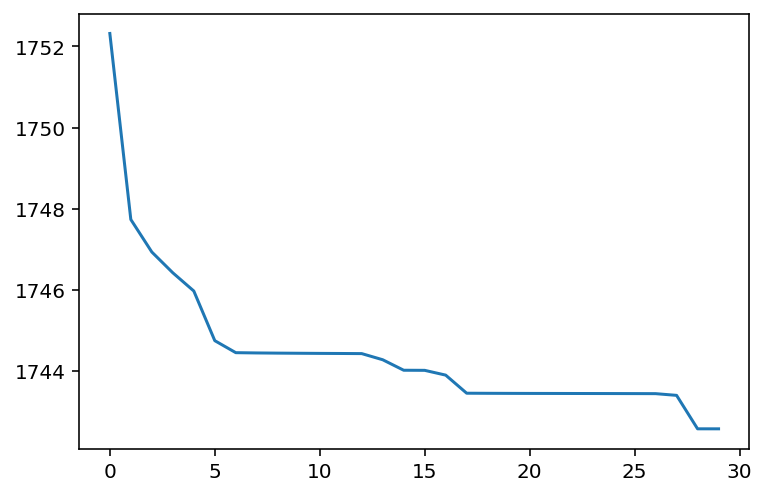

In [7]:
plt.plot(hist.history['loss'])

In [10]:
x_test = x_2d_res[504*204:744*204] 
reconstructed = autoencoder.predict(x_test)

In [14]:
err= reconstructed - x_2d_res[504*204:744*204] 

In [15]:
err

array([[ -6.00135183,  -7.00093496,  -7.00062239, ...,  -4.99783662,
         -1.00000596,  -2.00683689],
       [ -5.00345337,  -6.00281692,  -7.00204265, ...,  -2.99497315,
         -2.00003606,  -2.01551628],
       [-15.00002736, -12.00001371, -12.00000703, ...,  -6.99994099,
         -7.        ,  -7.00032556],
       ...,
       [-39.        , -35.        , -31.        , ..., -41.        ,
        -59.026577  , -59.026577  ],
       [-57.        , -63.        , -63.        , ..., -44.        ,
        -59.026577  , -59.026577  ],
       [-18.        , -16.        ,  -8.        , ..., -43.        ,
        -59.026577  , -59.026577  ]])

In [16]:
x_2d_res[504*204:744*204]

array([[ 7.      ,  8.      ,  8.      , ...,  5.      ,  2.      ,
         3.      ],
       [ 6.      ,  7.      ,  8.      , ...,  3.      ,  3.      ,
         3.      ],
       [16.      , 13.      , 13.      , ...,  7.      ,  8.      ,
         8.      ],
       ...,
       [40.      , 36.      , 32.      , ..., 41.      , 60.026577,
        60.026577],
       [58.      , 64.      , 64.      , ..., 44.      , 60.026577,
        60.026577],
       [19.      , 17.      ,  9.      , ..., 43.      , 60.026577,
        60.026577]])

In [22]:
x[0][0]

array([21. , 14. , 12. , 10. ,  9. ,  9. ,  9. , 10. , 13. , 21. , 17. ,
       11. ,  8. ,  6. ,  7. ,  6. ,  5. ,  5. ,  5. ,  6. ,  5. ,  6. ,
        7. ,  8. ,  8. , 11. , 11. , 10. ,  5. ,  4. ,  3. ,  2. ,  3. ,
        4. ,  5. , 12. , 15. , 14. , 13. , 13. , 13. , 13. , 15. , 19. ,
       24. , 30. , 31. , 30. , 32. , 35. , 37. , 19. , 18. , 15. , 21. ,
       25. , 21. , 24. , 22. , 24. , 23. , 26. , 28. , 28. , 29. , 20. ,
       20. , 20. , 21. , 22. , 22. , 24. , 34. , 14. ,  7. ,  5. ,  4. ,
        2. ,  2. ,  2. ,  2. ,  2. ,  1. ,  1. ,  1. ,  2.6,  4. ,  4. ,
        4.8,  5. ,  3.2,  5.8,  6.6,  8. ,  7. ,  6.4])